# Spectrogram VQGAN as a Neural Audio Codec
This notebook will guide you through the audio compression
demo with Spectrogram VQGAN for arbitrary audio. 

Compared to the state-of-the-art, 
this approach not only achieves **>10x** reduction in bitrate
but also supports a large variety of audio classes 
(300+ vs. 2 in the SotA).

This model is a part of our approach for 
"**Taming Visually Guided Sound Generation 🖼️ 👉 🔉**"
project and was never designed to be a neural audio
codec but it happened to be highly effective for this task. 

Spectrogram VQGAN is an upgraded 
[VQVAE](https://arxiv.org/abs/1711.00937) with
adversarial and perceptual losses, pre-trained in an 
auto-encoder fashion.
The model was pre-trained on
audio data from a general-purpose dataset 
([VGGSound](https://www.robots.ox.ac.uk/~vgg/data/vggsound/)). For details feel free to check out our paper and code.

[Project Page](https://v-iashin.github.io/specvqgan) • [Code](https://github.com/v-iashin/SpecVQGAN)

## Imports and Device Selection

In [5]:
try:
    import os
    from pathlib import Path
    import soundfile
    import torch
    import IPython
    import matplotlib.pyplot as plt
    
    %cd SpecVQGAN
    
    from feature_extraction.demo_utils import (calculate_codebook_bitrate,
                                               extract_melspectrogram,
                                               get_audio_file_bitrate,
                                               get_duration,
                                               load_neural_audio_codec)
    from sample_visualization import tensor_to_plt
    from torch.utils.data.dataloader import default_collate
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
except ModuleNotFoundError:
    # Cloning the repo from GitHub
    !git clone https://github.com/v-iashin/SpecVQGAN
    print('Some packages are not installed. Installing...')
    # Installing the environment
    !pip uninstall torchtext -y # otherwise fails on PytorchLightning import
    !pip install pytorch-lightning==1.2.10 omegaconf==2.0.6 streamlit==0.80 matplotlib==3.4.1 albumentations==0.5.2
    # We need to restart Colab Runtime because we installed new packages
    !for i in {1..20}; do echo "Packages have been installed. Please rerun the cell."; done
    import os
    os.kill(os.getpid(), 9)

[Errno 2] No such file or directory: 'SpecVQGAN'
/content/SpecVQGAN


## Select a Model
The model will be automatically downloaded given the `model_name`. 


In [2]:
model_name = '2021-05-19T22-16-54_vggsound_codebook'
log_dir = './logs'
# loading the models might take a few minutes
config, model, vocoder = load_neural_audio_codec(model_name, log_dir, device)

Using: 2021-05-19T22-16-54_vggsound_codebook (VGGSound Codebook)
./logs/2021-05-19T22-16-54_vggsound_codebook/checkpoints/last.ckpt
loaded pretrained LPAPS loss from specvqgan/modules/autoencoder/lpaps/vggishish16.pt
VQLPAPSWithDiscriminator running with hinge loss.
Restored from ./logs/2021-05-19T22-16-54_vggsound_codebook/checkpoints/last.ckpt


## Select an Audio

The model was pre-trained on `(mels x time) = (80 x 848)`
spectrograms. 
Considering the convolutional nature of the 
Spectrogram VQGAN, it can also be applied to sounds of 
a different duration. 

In [12]:
# Select an Audio
input_wav = './data/neural_audio_codec/music2/original.wav'

# Spectrogram Extraction
model_sr = config.data.params.sample_rate
duration = get_duration(input_wav)
spec = extract_melspectrogram(input_wav, sr=model_sr, duration=duration)
print(f'Audio Duration: {duration} seconds')
print('Original Spectrogram Shape:', spec.shape)

# Prepare Input
spectrogram = {'input': spec}
batch = default_collate([spectrogram])
batch['image'] = batch['input'].to(device)
x = model.get_input(batch, 'image')

using melspec_10s_22050hz
Audio Duration: 3.0 seconds
Original Spectrogram Shape: (80, 259)


## Encoding and Decoding

In [ ]:
with torch.no_grad():
    quant_z, diff, info = model.encode(x)
    xrec = model.decode(quant_z)

print('Compressed representation (it is all you need to recover the audio):')
F, T = quant_z.shape[-2:]
print(info[2].reshape(F, T))

## Displaying the Results

The input audio is 3.00 seconds long.
Codebook size is 1024 i.e. a codebook entry allocates 10 bits
SpecVQGAN bottleneck size: [5, 16]
Thus, bitrate is 0.26 kbps

Original audio (375 kbps):


Reconstructed audio (0.26 kbps):


Original Spectrogram:


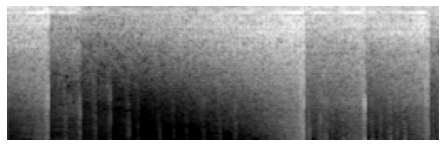

Reconstructed Spectrogram:


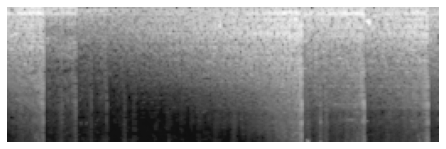

Compressed representation (it is all you need to recover the audio):
tensor([[  43,  822,  916,   81,  164,  280,  322,  549,  651,  675,  523,  678,
          169,  250,   27, 1012],
        [  66,  792,  392,  838,  334,   61,    1,  545,  960,  173,  894,  228,
         1022, 1015,  202,  534],
        [ 669,  471,  659,  322,  619,  893,  813,  313,  685,  239,  707,  521,
          684,  215,   49,  810],
        [ 478,  771,  278,  500,  820,  941,  806,  980,  303,  383,  343,  788,
          979,  504,  547,  475],
        [ 163,  407,  709,  483,  611,  887,  111,  348,  456,  793,  538,   98,
          236,  986,  547,  350]], device='cuda:0')


In [13]:
# Calculate Bitrate
bitrate = calculate_codebook_bitrate(duration, quant_z, model.quantize.n_e)
orig_bitrate = get_audio_file_bitrate(input_wav)

# Save and Display
x = x.squeeze(0)
xrec = xrec.squeeze(0)
# specs are in [-1, 1], making them in [0, 1]
wav_x = vocoder((x + 1) / 2).squeeze().detach().cpu().numpy()
wav_xrec = vocoder((xrec + 1) / 2).squeeze().detach().cpu().numpy()
# Save paths
x_save_path = Path(tmp_dir) / 'vocoded_orig_spec.wav'
xrec_save_path = Path(tmp_dir) / f'specvqgan_{bitrate:.2f}kbps.wav'
# Creating a temp folder which will hold the results
tmp_dir = os.path.join('./tmp/neural_audio_codec', Path(input_wav).parent.stem)
os.makedirs(tmp_dir, exist_ok=True)
# Save
soundfile.write(x_save_path, wav_x, model_sr, 'PCM_16')
soundfile.write(xrec_save_path, wav_xrec, model_sr, 'PCM_16')
# Display
print(f'Original audio ({orig_bitrate:.0f} kbps):')
IPython.display.display(IPython.display.Audio(x_save_path))
print(f'Reconstructed audio ({bitrate:.2f} kbps):')
IPython.display.display(IPython.display.Audio(xrec_save_path))
print('Original Spectrogram:')
IPython.display.display(tensor_to_plt(x, flip_dims=(2,)))
plt.close()
print('Reconstructed Spectrogram:')
IPython.display.display(tensor_to_plt(xrec, flip_dims=(2,)))
plt.close()
